In [114]:
from PIL import Image, ImageDraw, ImageFont
import calmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Plot Style
plt.style.use('ggplot')

In [115]:
def read_whatsapp(path):
    raw = open(path, encoding='utf-8')
    chats = raw.readlines()
    messages = []
    name = []
    time = []

    for line in chats:
        if len(line.split(' - '))!=1:
            if len(line.split(' - ')[1].split(': '))==2:
                name.append(line.split(' - ')[1].split(':')[0])
                messages.append(line.split(' - ')[1].split(':')[1].rstrip('\n'))
                time.append(line.split(' - ')[0])
        else:
            messages[-1] = messages[-1] + " " + line

    df = pd.DataFrame({"message":messages, "name":name, 'time':time})
    df["time"] = pd.to_datetime(df["time"])


    return df

In [116]:
chat = read_whatsapp("WhatsApp Chat with Team PUBG.txt")

In [117]:
def timeline(df):
    days = (df.time.iloc[-1] - df.time.iloc[0]).days
    first_day = datetime.strftime(df.time.iloc[0], format="%A, %d %b %Y")
    last_day = datetime.strftime(df.time.iloc[-1], format="%A, %d %b %Y")

    day_img = Image.open("img/pubg2.jpg")
    img = ImageDraw.Draw(day_img)
    font = ImageFont.truetype(font="corbel.ttf", size=50)
    font_day = ImageFont.truetype(font="corbel.ttf", size=40)
    font_date = ImageFont.truetype(font="corbel.ttf", size=50)
    img.text((290,130), str(days), font=font, fill=(0, 0, 0))
    img.text((360,140), "DIas", font=font_day, fill=(0, 0, 0))
    img.text((120,50), first_day, font=font_date, fill=(0, 0, 0))
    img.text((120,220), last_day, font=font_date, fill=(0, 0, 0))
    return day_img

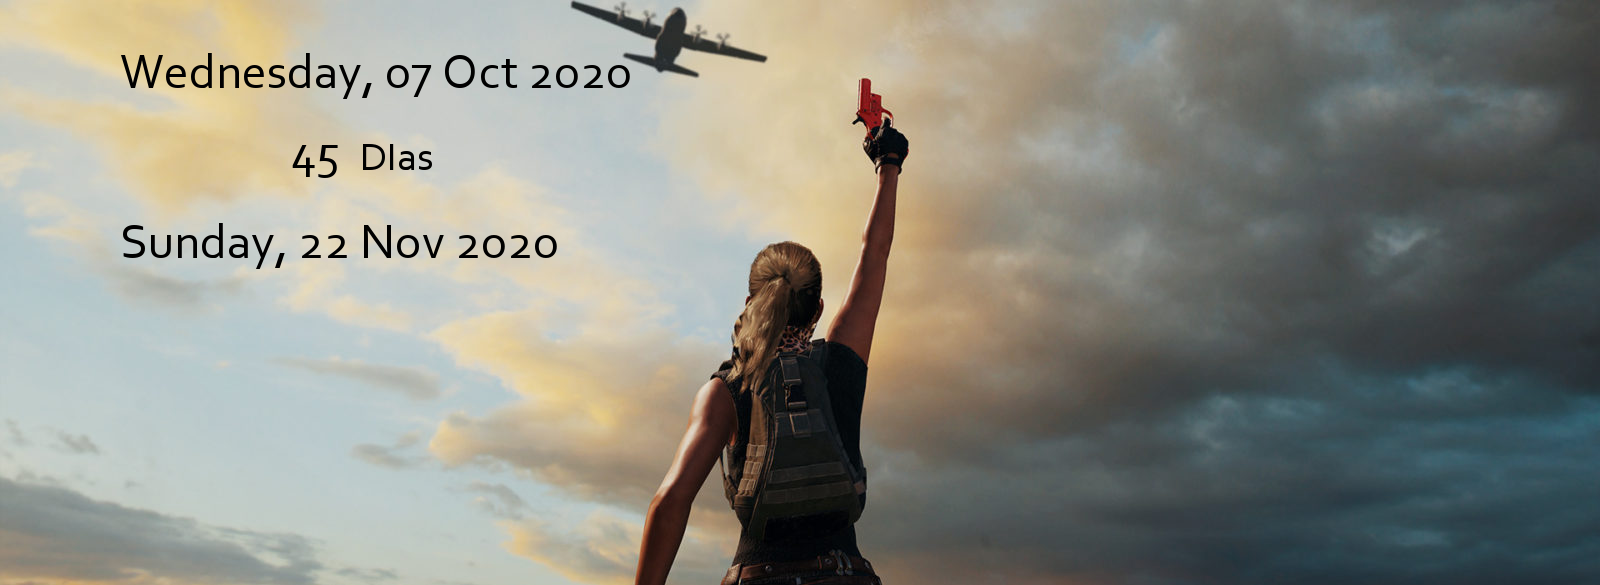

In [118]:
timeline(chat)

In [119]:
# Read Data Frame
df = pd.read_table('WhatsApp Chat with Team PUBG.txt',names=['Date'])
df.head()

,Date
0,"2020-10-05, 9:29 p.m. - Messages and calls ar..."
1,"2020-08-24, 8:23 p.m. - Mandi Basterrica creat..."
2,"2020-08-24, 8:23 p.m. - You were added"
3,"2020-10-07, 11:08 p.m. - Mandi Basterrica: Ret..."
4,"2020-10-07, 11:11 p.m. - Edu: Dale"


In [120]:
def messages_summary(df):
    total_message = len(df.index)
    average_message_day = df.set_index(df.time).message.resample("D").count().mean()
    average_message_week = df.set_index(df.time).message.resample("W").count().mean()
    average_message_month = df.set_index(df.time).message.resample("M").count().mean()
    users = {user: df[df.name == user] for user in df.name.unique()}

    chat_img = Image.open("img/chat_1.png")
    img = ImageDraw.Draw(chat_img)
    font = ImageFont.truetype(font="arial.ttf", size=20)
    font_2 = ImageFont.truetype(font="arial.ttf", size=13)
    img.text((100,100), str(total_message), font=font, fill=(0,128,128))
    img.text((78,120), "Messages", font=font, fill=(0,128,128))
    img.text((240,70), ("Daily Average messages {:0.0f}".format(average_message_day)), font=font_2, fill=(0,128,128))
    img.text((240,90), ("Weekly Average messages {:0.0f}".format(average_message_week)), font=font_2, fill=(0,128,128))
    img.text((240,110), ("Monthly Average messages {:0.0f}".format(average_message_month)), font=font_2, fill=(0,128,128))
    for i, user in enumerate(users):
        img.text((240,120+(i+1)*20), ("Number of messages " + user + " sent {:0.0f}".format(len(users[user].index))), font=font_2, fill=(0,128,128))
    
    return chat_img

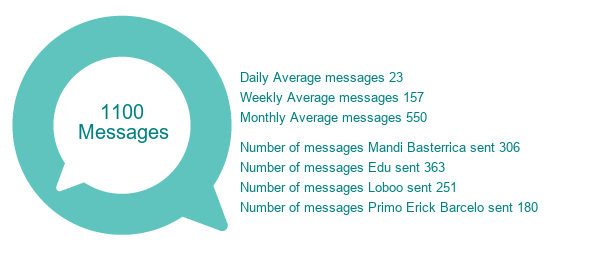

In [139]:
messages_summary(chat)

In [140]:
def chat_reply(df):
    dff = df.copy()
    dff["response_time"] = dff.time.diff()

    dff["response_time_s"] = dff.response_time - timedelta(hours=12)
    dff["response_time_s"] = dff.response_time_s.apply(lambda x: x.total_seconds())
    response_time_obj = dff[dff["response_time_s"] < 0]
    response_time_obj["response_time_s"] = response_time_obj.response_time.values.astype("int64")

    bales_chat = response_time_obj.groupby("name").mean()
    bales_chat["response_time_s"] = pd.to_timedelta(bales_chat["response_time_s"])

    a=bales_chat.response_time_s.apply(lambda x: x.total_seconds())
    minutes=a//60
    seconds=a-(minutes*60)

    value=bales_chat.response_time_s.values.astype("float64")/60/1000000000
    ax=sns.barplot(x=value, y=bales_chat.index, color='green')
    ax.set_xlabel('Min')
    for i in range(len(bales_chat.index)):
        plt.text(x = value[i]-value[i]+0.1 , y = i, s = '{:02} minutos {:02} seg'.format(int(minutes[i]), int(seconds[i])), size = 14, withdash=True, color="snow")
    plt.title("¿Quién recibe una respuesta rápida?", fontsize=14)
    plt.savefig("chat_reply.jpg")
    plt.show()

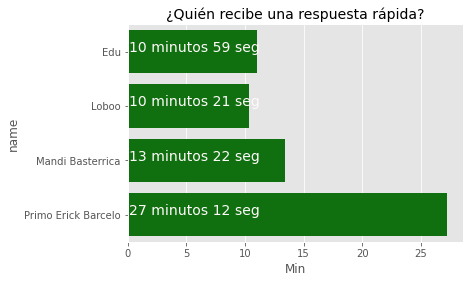

In [141]:
chat_reply(chat)

In [142]:

df = pd.read_table('WhatsApp Chat with Team PUBG.txt',names=['Date'])
df.head()

,Date
0,"2020-10-05, 9:29 p.m. - Messages and calls ar..."
1,"2020-08-24, 8:23 p.m. - Mandi Basterrica creat..."
2,"2020-08-24, 8:23 p.m. - You were added"
3,"2020-10-07, 11:08 p.m. - Mandi Basterrica: Ret..."
4,"2020-10-07, 11:11 p.m. - Edu: Dale"


In [145]:
df[['Time','User']] = df["Time"].str.split(" - ",expand=True,n=1)
df

,Date,Time,User
0,,"2020-10-05, 9:29 p.m.",Messages and calls are end-to-end encrypted. N...
1,"2020-08-24,",8:23 p.m.,"Mandi Basterrica created group ""Team PUBG"""
2,"2020-08-24,",8:23 p.m.,You were added
3,"2020-10-07,",11:08 p.m.,Mandi Basterrica: Retaaaaa
4,"2020-10-07,",11:11 p.m.,Edu: Dale
...,...,...,...
1101,"2020-11-22,",9:03 p.m.,Edu: Jajajaja
1102,"2020-11-22,",10:54 p.m.,Loboo: No tengo
1103,"2020-11-22,",10:55 p.m.,Edu: Ya se calmo todo lobo?
1104,"2020-11-22,",10:57 p.m.,Loboo: Si


In [144]:
def weekly_activity(df):
    df.set_index(df["time"], inplace=True)

    users = {user: df[df.name == user] for user in df.name.unique()}

    for user in users:
        users[user] = users[user]['message'].resample('W').count()

    fig,ax=plt.subplots()
    for name in users:
        ax.plot(users[name], linewidth=3)


    plt.title("Weekly Number of Messages", fontsize=30)

    fig.set_size_inches(20,7)
    plt.legend(users.keys(), loc='upper left', prop={'size': 15})
    ax.grid(True, axis='y')
    ax.set_ylabel('Numero de mensajes', fontsize=15)
    ax.set_xlabel('Dates', fontsize=15)

    dates = list(pd.to_datetime(users[name].index.to_series(), 
                               format='%Y00%m').apply(lambda x: x.strftime('%b-%Y')))
    dates = list(set([date.replace('-', ' \n') for date in dates]))
    ax.set_xticks(dates)
    ax.set_xticklabels(dates, fontsize=12)
    plt.savefig("weekly_activity.jpg")
    plt.show()

ConversionError: Failed to convert value(s) to axis units: ['Nov \n2020', 'Oct \n2020']

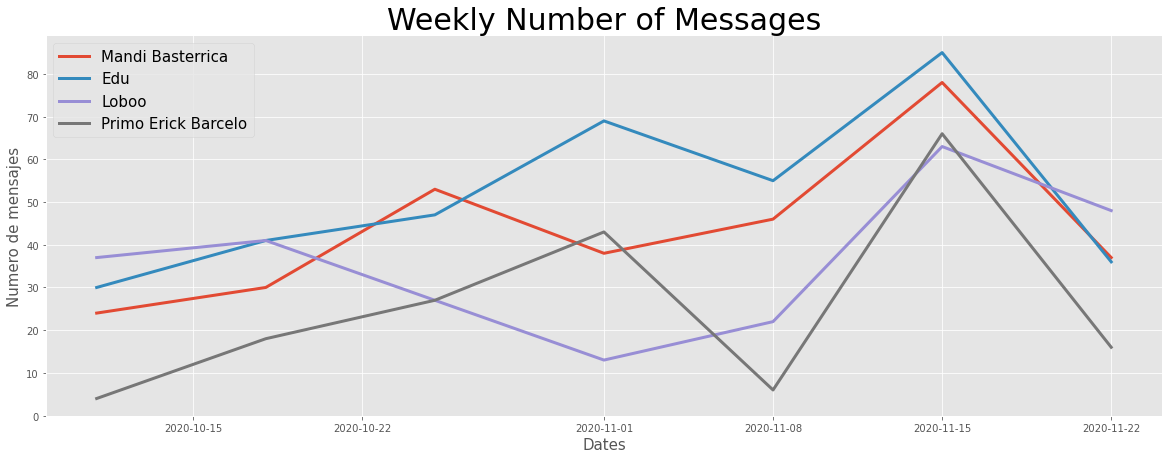

In [127]:
weekly_activity(chat)

In [131]:
### actividad Multimedia

In [151]:
df[['User','Message']] = df["User"].str.split(":",expand=True,n=1)
df

,Date,Time,User,Message
0,,"2020-10-05, 9:29 p.m.",Messages and calls are end-to-end encrypted. N...,None
1,"2020-08-24,",8:23 p.m.,"Mandi Basterrica created group ""Team PUBG""",None
2,"2020-08-24,",8:23 p.m.,You were added,None
3,"2020-10-07,",11:08 p.m.,Mandi Basterrica,Retaaaaa
4,"2020-10-07,",11:11 p.m.,Edu,Dale
...,...,...,...,...
1101,"2020-11-22,",9:03 p.m.,Edu,Jajajaja
1102,"2020-11-22,",10:54 p.m.,Loboo,No tengo
1103,"2020-11-22,",10:55 p.m.,Edu,Ya se calmo todo lobo?
1104,"2020-11-22,",10:57 p.m.,Loboo,Si


In [152]:
def daily_activity_bar(df):
    df["DayofWeek"]=df.index.dayofweek
    df["DayofWeek"].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}, inplace=True)

    daily = df.groupby(['DayofWeek']).count()
    daily = daily.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

    fig=plt.gcf()
    ax=plt.subplot()
    sns.barplot(y=daily['message'], x=daily.index, color="blue")
    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Actividad Diaria",fontsize=14)
    plt.savefig('daily_activity_bar.jpg')
    plt.show()

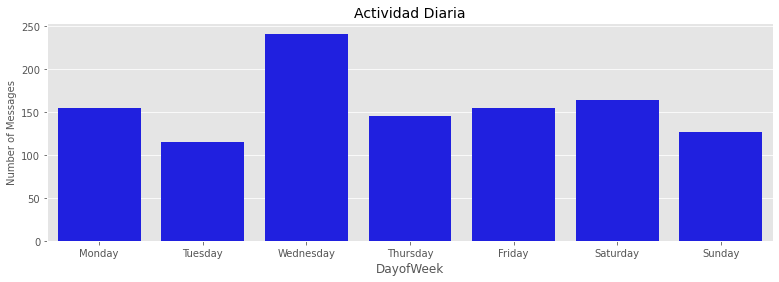

In [153]:
daily_activity_bar(chat)

In [158]:
def hourly_activity_map(df):
    df['Hour']=pd.to_datetime(df.index.to_series()).apply(lambda x: x.strftime('%H'))
    hourly = df.groupby("Hour").count()

    fig=plt.gcf()
    ax=plt.subplot()

    plt.fill_between( x=hourly.index, y1=hourly.message, color="red", alpha=0.4)
    plt.plot(hourly.message, color="turquoise", alpha=0.6)

    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Hora con mas actividad",fontsize=14)
    plt.savefig('hourly_activity_map.jpg')
    plt.show()

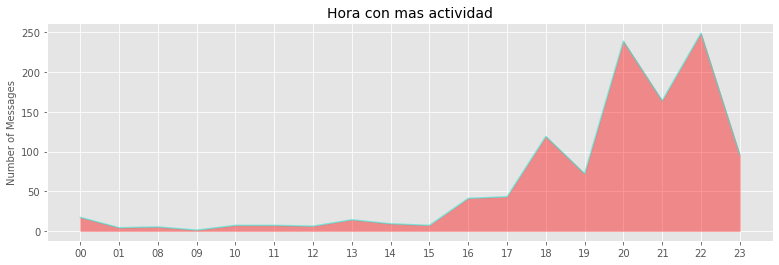

In [159]:
hourly_activity_map(chat)

In [160]:
### emojis

In [167]:
emojis=[]
for string in df.Message:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI:
            emojis.append(each)

In [168]:
emoji_df = pd.DataFrame(emojis)

In [169]:
emoji_df = emoji_df[0].value_counts().head(10).reset_index()
emoji_df.columns = ['Emojis', 'Frequency']
emoji_messages = emoji_df.Frequency.sum()
emoji_df

,Emojis,Frequency
0,😂,37
1,🤣,4
2,🤭,3
3,🥳,2
4,😉,2
5,🤮,2
6,😎,2
7,😞,1
8,☹,1
9,🤙,1
